# Predicting CAGE-tags

In [1]:
#!pip install rpy2
#!pip install tzlocal
#!conda install --yes -c bioconda bedtools samtools 

In [2]:
import os
%load_ext rpy2.ipython

from IPython.display import Image

In [3]:
datadir = '../data'


Run CAGE tag prediction with different sequence encoding orders.
This part is rather time consuming, to rerun this step, remove the hashtags.

In [4]:
#!python cage_prediction.py -inputpath {datadir} -order 1
#!python cage_prediction.py -inputpath {datadir} -order 2
#!python cage_prediction.py -inputpath {datadir} -order 3

Illustrate the correlation between predicted and measured CAGE signal

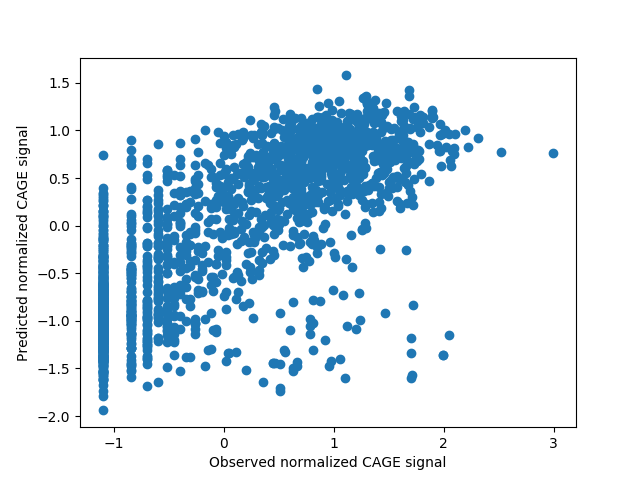

In [5]:
Image(os.path.join('../results_cage_promoters_order3', 'cage_promoter_testchrom_agreement.png'))

## Summary of the performances

In [6]:
%%R
cage1 = read.table("../results_cage_promoters_order1/gridsearch_cage_prediction.tsv", stringsAsFactors=F)
cage2 = read.table("../results_cage_promoters_order2/gridsearch_cage_prediction.tsv", stringsAsFactors=F)
cage3 = read.table("../results_cage_promoters_order3/gridsearch_cage_prediction.tsv", stringsAsFactors=F)

df = rbind(cage1,cage2, cage3)
df$model=""

df$model[df$inputs=="dna_only"] = 'DNA'
df$model[df$inputs=="epi_only"] = 'Chromatin'
df$model[df$inputs=="epi_dna" & df$pretrained=="pretrained"] = 'joint_pretrained'
df$model[df$inputs=="epi_dna" & df$pretrained=="randominit"] = 'joint_randominit'

df = df[,c(4, 6, 15)]

se = function(x) sd(x)/sqrt(length(x))

cor_mean = aggregate(df[,2], by=df[,c(1, 3)], FUN=mean)
names(cor_mean)[3]= "cor_mean"
cor_se = aggregate(df[,2], by=df[,c(1, 3)], FUN=se)
cor_mean["cor_se"] = cor_se[3]

print(cor_mean)

   dnaorder            model  cor_mean       cor_se
1         1        Chromatin 0.7759645 0.0003777525
2         2        Chromatin 0.7762133 0.0002825768
3         3        Chromatin 0.7762052 0.0001803543
4         1              DNA 0.5246112 0.0037245426
5         2              DNA 0.5648587 0.0099083251
6         3              DNA 0.5837345 0.0023455693
7         1 joint_pretrained 0.7785877 0.0004917560
8         2 joint_pretrained 0.7853581 0.0006475842
9         3 joint_pretrained 0.7845305 0.0011786890
10        1 joint_randominit 0.7771940 0.0004839985
11        2 joint_randominit 0.7813493 0.0005128702
12        3 joint_randominit 0.7818415 0.0008029399


In [7]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

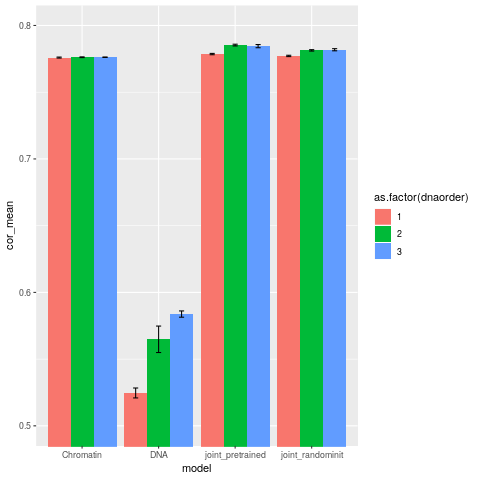

In [8]:
%%R

ggplot(cor_mean, aes(x=model, y=cor_mean, fill=as.factor(dnaorder))) +
      geom_bar(position=position_dodge(), stat="identity") +
      coord_cartesian(ylim=c(.50,.8)) +
      geom_errorbar(aes(ymin=cor_mean-cor_se, ymax=cor_mean+cor_se),
                    width=.2, position=position_dodge(.9))

